# Understanding Learning Curves - 실습 노트북

이 노트북은 모델 학습 중 학습 곡선(Learning Curves)을 이해하고 해석하는 방법을 다룹니다.

## 목차
1. 환경 설정 및 라이브러리 설치
2. 학습 곡선이란?
3. Loss Curves와 Accuracy Curves
4. 건강한 학습 곡선
5. Overfitting 감지 및 해결
6. Underfitting 감지 및 해결
7. Erratic Learning Curves 해결
8. 실전 예제

## 1. 환경 설정 및 라이브러리 설치

In [6]:
# 필요한 라이브러리 설치
!pip install transformers==4.0.0 datasets==4.0.0 evaluate wandb accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 34.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [2]:
# 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import load_dataset
import evaluate
import wandb

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

## 2. 학습 곡선이란?

학습 곡선은 학습 과정 동안 모델의 성능 지표를 시각적으로 나타낸 것입니다.

주요 두 가지 곡선:
- **Loss Curves**: 모델의 오류(loss)가 학습 단계나 에폭에 따라 어떻게 변하는지 보여줍니다
- **Accuracy Curves**: 학습 단계나 에폭에 따른 정확한 예측의 비율을 보여줍니다

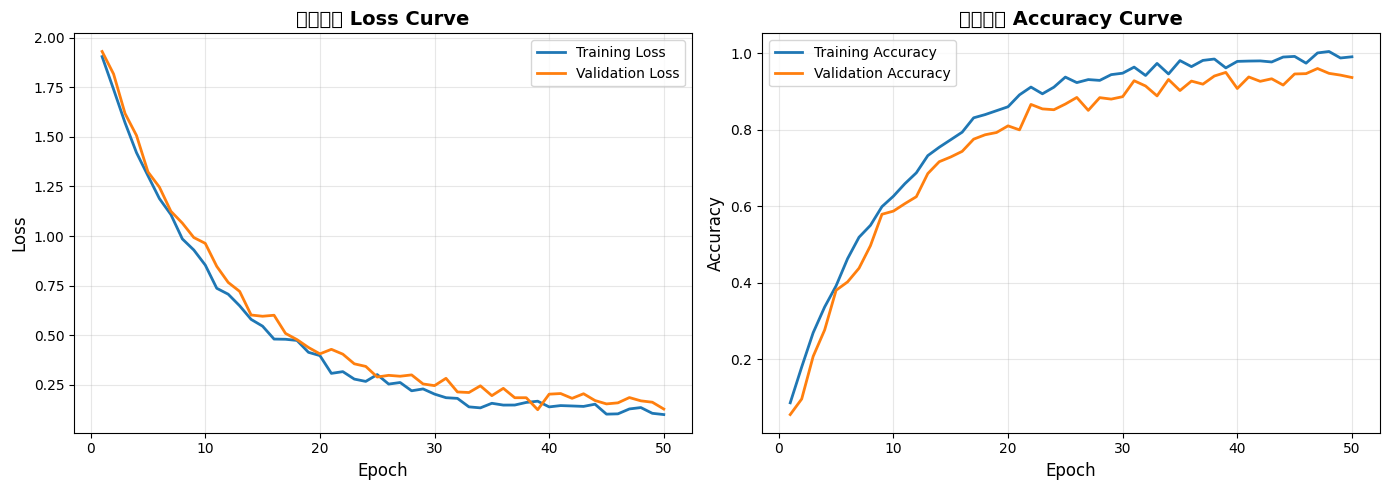

In [3]:
# 이상적인 학습 곡선 시뮬레이션
def plot_ideal_learning_curves():
    epochs = np.arange(1, 51)

    # Loss curve 시뮬레이션
    train_loss = 2.0 * np.exp(-0.1 * epochs) + 0.1 + np.random.normal(0, 0.02, len(epochs))
    val_loss = 2.0 * np.exp(-0.1 * epochs) + 0.15 + np.random.normal(0, 0.03, len(epochs))

    # Accuracy curve 시뮬레이션 (계단 형태)
    train_acc = 1 - np.exp(-0.1 * epochs) + np.random.normal(0, 0.01, len(epochs))
    val_acc = 1 - np.exp(-0.1 * epochs) - 0.05 + np.random.normal(0, 0.015, len(epochs))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_loss, label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('이상적인 Loss Curve', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_acc, label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('이상적인 Accuracy Curve', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_ideal_learning_curves()

## 3. 데이터셋 준비 및 전처리

MRPC (Microsoft Research Paraphrase Corpus) 데이터셋을 사용하여 실습을 진행합니다.

In [4]:
# MRPC 데이터셋 로드
dataset = load_dataset("glue", "mrpc")
print("데이터셋 구조:")
print(dataset)
print("\n샘플 데이터:")
print(dataset["train"][0])

README.md: 0.00B [00:00, ?B/s]

HfHubHTTPError: 404 Client Error: Not Found for url: https://huggingface.co/api/datasets/glue/revision/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (Request ID: Root=1-6979681b-686c2f5c2e414d985785bb47;510c0b4c-6db8-4557-a8d7-b98de45e97c9)

Sorry, we can't find the page you are looking for.

In [ ]:
# 토크나이저 로드
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 토크나이징 함수
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# 데이터셋 토크나이징
tokenized_datasets = dataset.map(tokenize_function, batched=True)
print("토크나이징 완료!")
print(f"Training 샘플 수: {len(tokenized_datasets['train'])}")
print(f"Validation 샘플 수: {len(tokenized_datasets['validation'])}")

In [ ]:
# Data Collator 설정
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 평가 메트릭 정의
metric = evaluate.load("glue", "mrpc")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## 4. 기본 학습 - Weights & Biases를 사용한 추적

Weights & Biases를 사용하여 학습 곡선을 추적합니다.

In [ ]:
# Weights & Biases 로그인 (선택사항)
# wandb.login()

# 또는 익명 모드로 사용
wandb.init(project="learning-curves-tutorial", name="basic-training") # project안의 특정 run
# mode="disabled"를 제거하면 실제로 W&B에 로깅됩니다

In [ ]:
# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

# 기본 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=50,
    save_steps=100,
    logging_steps=10,  # 10 스텝마다 메트릭 로깅
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    report_to="wandb",  # Weights & Biases로 로그 전송
    warmup_steps=100,
    weight_decay=0.01,
)

# Trainer 초기화
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer 초기화 완료!")

In [ ]:
# 학습 시작 (주석 처리됨 - 실제로 실행하려면 주석 해제)
# trainer.train()

print("학습을 실행하려면 위의 주석을 해제하세요.")
print("학습 완료 후 W&B 대시보드에서 학습 곡선을 확인할 수 있습니다.")

## 5. Overfitting 감지 및 해결

Overfitting은 모델이 학습 데이터에 과도하게 최적화되어 검증 데이터에서 성능이 저하되는 현상입니다.

### 증상:
- 학습 손실은 계속 감소하지만 검증 손실은 증가하거나 정체
- 학습 정확도와 검증 정확도 사이에 큰 차이

### 해결책:
- Early Stopping 사용
- Regularization (Dropout, Weight Decay)
- 데이터 증강
- 모델 복잡도 감소

In [ ]:
# Overfitting 시뮬레이션 시각화
def plot_overfitting_example():
    epochs = np.arange(1, 51)

    # Overfitting 패턴
    train_loss = 2.0 * np.exp(-0.15 * epochs) + 0.05
    val_loss = 2.0 * np.exp(-0.1 * epochs[:20]).tolist() + \
               (0.3 + 0.02 * np.arange(30)).tolist()

    train_acc = 1 - np.exp(-0.15 * epochs) + 0.02
    val_acc = (1 - np.exp(-0.1 * epochs[:20])).tolist() + \
              (0.85 - 0.01 * np.arange(30)).tolist()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_loss, label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', linewidth=2, color='orange')
    ax1.axvline(x=20, color='red', linestyle='--', label='Overfitting 시작', alpha=0.7)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Overfitting - Loss Curve', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_acc, label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2, color='orange')
    ax2.axvline(x=20, color='red', linestyle='--', label='Overfitting 시작', alpha=0.7)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Overfitting - Accuracy Curve', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_overfitting_example()

In [ ]:
# Early Stopping을 사용한 Overfitting 방지
model_early_stop = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

training_args_early_stop = TrainingArguments(
    output_dir="./results-early-stop",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,  # 최상의 모델 로드
    metric_for_best_model="eval_loss",  # 평가 기준
    greater_is_better=False,  # loss는 낮을수록 좋음
    num_train_epochs=10,  # 높게 설정하지만 early stopping으로 조기 종료
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=10,
)

# Early Stopping Callback 추가
trainer_early_stop = Trainer(
    model=model_early_stop,
    args=training_args_early_stop,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # 3 에폭 동안 개선 없으면 중단
)

print("Early Stopping이 적용된 Trainer 생성 완료!")
print("early_stopping_patience=3: 검증 손실이 3번 연속 개선되지 않으면 학습 중단")

In [ ]:
# 학습 시작 (주석 처리됨)
# trainer_early_stop.train()

print("Early Stopping 학습을 실행하려면 위의 주석을 해제하세요.")

## 6. Underfitting 감지 및 해결

Underfitting은 모델이 데이터의 패턴을 충분히 학습하지 못한 상태입니다.

### 증상:
- 학습 손실과 검증 손실 모두 높게 유지
- 학습 초기에 성능이 정체
- 예상보다 낮은 학습 정확도

### 해결책:
- 모델 용량 증가
- 더 긴 학습 시간
- 학습률 조정
- 데이터 품질 확인

In [ ]:
# Underfitting 시뮬레이션 시각화
def plot_underfitting_example():
    epochs = np.arange(1, 51)

    # Underfitting 패턴 - 성능이 빠르게 정체
    train_loss = 1.5 * np.exp(-0.05 * epochs) + 0.8 + np.random.normal(0, 0.03, len(epochs))
    val_loss = 1.5 * np.exp(-0.05 * epochs) + 0.85 + np.random.normal(0, 0.04, len(epochs))

    train_acc = 0.4 + 0.2 * (1 - np.exp(-0.05 * epochs)) + np.random.normal(0, 0.01, len(epochs))
    val_acc = 0.35 + 0.2 * (1 - np.exp(-0.05 * epochs)) + np.random.normal(0, 0.015, len(epochs))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_loss, label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_loss, label='Validation Loss', linewidth=2, color='orange')
    ax1.axhline(y=0.8, color='red', linestyle='--', label='높은 손실 유지', alpha=0.5)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Underfitting - Loss Curve', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_acc, label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2, color='orange')
    ax2.axhline(y=0.6, color='red', linestyle='--', label='낮은 정확도', alpha=0.5)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Underfitting - Accuracy Curve', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_underfitting_example()

In [ ]:
# Underfitting 해결 - 더 긴 학습 시간
training_args_longer = TrainingArguments(
    output_dir="./results-longer",
    eval_strategy="steps",
    eval_steps=100,
    num_train_epochs=10,  # 5 에폭에서 10 에폭으로 증가
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=10,
    learning_rate=5e-5,  # 학습률 조정
)

print("Underfitting 해결을 위한 설정:")
print(f"- 에폭 수 증가: 10")
print(f"- 학습률 조정: 5e-5")

## 7. Erratic Learning Curves 해결

불규칙한 학습 곡선은 학습이 효과적으로 이루어지지 않고 있음을 나타냅니다.

### 증상:
- 손실이나 정확도의 빈번한 변동
- 높은 분산 또는 불안정성
- 명확한 추세 없이 성능이 진동

### 해결책:
- 학습률 감소
- 배치 크기 증가
- Gradient Clipping
- 더 나은 데이터 전처리

In [ ]:
# Erratic Learning Curves 시뮬레이션 시각화
def plot_erratic_example():
    epochs = np.arange(1, 51)

    # Erratic 패턴 - 심한 변동
    train_loss = 1.0 * np.exp(-0.05 * epochs) + 0.3 + np.random.normal(0, 0.2, len(epochs))
    val_loss = 1.0 * np.exp(-0.05 * epochs) + 0.35 + np.random.normal(0, 0.25, len(epochs))

    train_acc = 0.5 + 0.3 * (1 - np.exp(-0.05 * epochs)) + np.random.normal(0, 0.1, len(epochs))
    val_acc = 0.45 + 0.3 * (1 - np.exp(-0.05 * epochs)) + np.random.normal(0, 0.12, len(epochs))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_loss, label='Training Loss', linewidth=2, alpha=0.7)
    ax1.plot(epochs, val_loss, label='Validation Loss', linewidth=2, alpha=0.7, color='orange')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Erratic - Loss Curve (불안정)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_acc, label='Training Accuracy', linewidth=2, alpha=0.7)
    ax2.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2, alpha=0.7, color='orange')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Erratic - Accuracy Curve (불안정)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_erratic_example()

In [ ]:
# Erratic Curves 해결 - 학습률 감소 및 배치 크기 증가
training_args_stable = TrainingArguments(
    output_dir="./results-stable",
    eval_strategy="steps",
    eval_steps=100,
    num_train_epochs=5,
    learning_rate=1e-5,  # 학습률 감소 (기존 5e-5에서)
    per_device_train_batch_size=32,  # 배치 크기 증가 (기존 16에서)
    per_device_eval_batch_size=32,
    logging_steps=10,
    warmup_steps=100,
    weight_decay=0.01,
    max_grad_norm=1.0,  # Gradient Clipping
)

print("Erratic Curves 해결을 위한 설정:")
print(f"- 학습률 감소: 1e-5")
print(f"- 배치 크기 증가: 32")
print(f"- Gradient Clipping: max_grad_norm=1.0")

## 8. 학습 곡선 비교 - 건강한 vs 문제 있는 곡선

In [ ]:
# 모든 패턴을 한 번에 비교
def plot_all_patterns_comparison():
    epochs = np.arange(1, 51)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. 건강한 곡선
    train_loss = 2.0 * np.exp(-0.1 * epochs) + 0.1 + np.random.normal(0, 0.02, len(epochs))
    val_loss = 2.0 * np.exp(-0.1 * epochs) + 0.15 + np.random.normal(0, 0.03, len(epochs))
    axes[0, 0].plot(epochs, train_loss, label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('1. 건강한 학습 곡선 ✓', fontsize=12, fontweight='bold', color='green')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')

    # 2. Overfitting
    train_loss = 2.0 * np.exp(-0.15 * epochs) + 0.05
    val_loss = 2.0 * np.exp(-0.1 * epochs[:20]).tolist() + (0.3 + 0.02 * np.arange(30)).tolist()
    axes[0, 1].plot(epochs, train_loss, label='Training Loss', linewidth=2)
    axes[0, 1].plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    axes[0, 1].axvline(x=20, color='red', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('2. Overfitting ⚠', fontsize=12, fontweight='bold', color='orange')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')

    # 3. Underfitting
    train_loss = 1.5 * np.exp(-0.05 * epochs) + 0.8 + np.random.normal(0, 0.03, len(epochs))
    val_loss = 1.5 * np.exp(-0.05 * epochs) + 0.85 + np.random.normal(0, 0.04, len(epochs))
    axes[1, 0].plot(epochs, train_loss, label='Training Loss', linewidth=2)
    axes[1, 0].plot(epochs, val_loss, label='Validation Loss', linewidth=2)
    axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('3. Underfitting ⚠', fontsize=12, fontweight='bold', color='orange')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')

    # 4. Erratic
    train_loss = 1.0 * np.exp(-0.05 * epochs) + 0.3 + np.random.normal(0, 0.2, len(epochs))
    val_loss = 1.0 * np.exp(-0.05 * epochs) + 0.35 + np.random.normal(0, 0.25, len(epochs))
    axes[1, 1].plot(epochs, train_loss, label='Training Loss', linewidth=2, alpha=0.7)
    axes[1, 1].plot(epochs, val_loss, label='Validation Loss', linewidth=2, alpha=0.7)
    axes[1, 1].set_title('4. Erratic (불안정) ⚠', fontsize=12, fontweight='bold', color='red')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_all_patterns_comparison()

## 9. 학습 곡선 분석 체크리스트

### 학습 중 확인사항:
1. **Loss Convergence**: 손실이 여전히 감소하고 있는가, 아니면 정체되었는가?
2. **Overfitting 징후**: 검증 손실이 증가하는 동안 학습 손실은 감소하는가?
3. **Learning Rate**: 곡선이 너무 불규칙한가(LR 너무 높음) 또는 너무 평평한가(LR 너무 낮음)?
4. **안정성**: 급격한 상승이나 하락이 있는가?

### 학습 후 분석:
1. **최종 성능**: 모델이 허용 가능한 성능 수준에 도달했는가?
2. **효율성**: 더 적은 에폭으로도 같은 성능을 달성할 수 있었는가?
3. **일반화**: 학습과 검증 성능이 얼마나 가까운가?
4. **추세**: 추가 학습이 성능을 개선할 가능성이 있는가?

In [ ]:
# 학습 곡선 분석 함수
def analyze_learning_curves(train_losses, val_losses, train_accs, val_accs):
    """
    학습 곡선을 분석하고 잠재적 문제를 식별합니다.

    Parameters:
    - train_losses: 학습 손실 리스트
    - val_losses: 검증 손실 리스트
    - train_accs: 학습 정확도 리스트
    - val_accs: 검증 정확도 리스트
    """
    print("="*60)
    print("학습 곡선 분석 결과")
    print("="*60)

    # 1. 최종 성능
    print("\n1. 최종 성능:")
    print(f"   - 최종 학습 손실: {train_losses[-1]:.4f}")
    print(f"   - 최종 검증 손실: {val_losses[-1]:.4f}")
    print(f"   - 최종 학습 정확도: {train_accs[-1]:.4f}")
    print(f"   - 최종 검증 정확도: {val_accs[-1]:.4f}")

    # 2. Overfitting 감지
    print("\n2. Overfitting 검사:")
    loss_gap = train_losses[-1] - val_losses[-1]
    acc_gap = train_accs[-1] - val_accs[-1]

    if abs(loss_gap) > 0.3 or acc_gap > 0.1:
        print("   ⚠ Overfitting 가능성이 있습니다!")
        print(f"   - 손실 차이: {loss_gap:.4f}")
        print(f"   - 정확도 차이: {acc_gap:.4f}")
        print("   권장사항: Early Stopping, Dropout 증가, 데이터 증강")
    else:
        print("   ✓ Overfitting 징후가 보이지 않습니다.")

    # 3. Underfitting 감지
    print("\n3. Underfitting 검사:")
    if train_losses[-1] > 0.5 and val_losses[-1] > 0.5:
        print("   ⚠ Underfitting 가능성이 있습니다!")
        print("   권장사항: 더 긴 학습, 모델 용량 증가, 학습률 조정")
    else:
        print("   ✓ Underfitting 징후가 보이지 않습니다.")

    # 4. 수렴 분석
    print("\n4. 수렴 분석:")
    recent_loss_change = abs(train_losses[-1] - train_losses[-5]) if len(train_losses) >= 5 else 0
    if recent_loss_change < 0.01:
        print("   ✓ 모델이 수렴한 것으로 보입니다.")
    else:
        print("   → 모델이 아직 학습 중입니다. 추가 학습이 도움될 수 있습니다.")

    print("\n" + "="*60)

# 예시 사용법
# 시뮬레이션된 데이터로 분석
epochs = 20
example_train_losses = list(2.0 * np.exp(-0.1 * np.arange(epochs)) + 0.1)
example_val_losses = list(2.0 * np.exp(-0.1 * np.arange(epochs)) + 0.15)
example_train_accs = list(1 - np.exp(-0.1 * np.arange(epochs)))
example_val_accs = list(1 - np.exp(-0.1 * np.arange(epochs)) - 0.05)

analyze_learning_curves(example_train_losses, example_val_losses,
                       example_train_accs, example_val_accs)

## 10. 주요 개념 정리

### 💡 핵심 요약:

1. **학습 곡선의 중요성**
   - 모델 학습 진행 상황을 이해하는 필수 도구
   - 손실과 정확도 곡선을 모두 모니터링해야 함

2. **Overfitting**
   - 학습/검증 성능의 괴리로 나타남
   - Early Stopping과 적절한 정규화로 해결

3. **Underfitting**
   - 학습과 검증 데이터 모두에서 낮은 성능
   - 모델 용량 증가, 더 긴 학습으로 해결

4. **도구 활용**
   - Weights & Biases 같은 도구로 학습 곡선 추적이 용이
   - Early Stopping과 정규화가 대부분의 문제 해결

### 🔬 다음 단계:
- 자신의 파인튜닝 실험에서 학습 곡선 분석 연습
- 다양한 하이퍼파라미터를 시도하고 곡선 모양 관찰
- 실습 경험이 학습 진행 상황을 읽는 직관을 개발하는 가장 좋은 방법

## 11. 실습 과제

### 과제 1: 기본 학습 실행
위의 기본 학습 코드 주석을 해제하고 실제로 모델을 학습시켜보세요.

### 과제 2: Early Stopping 실험
Early Stopping의 patience 값을 변경하면서 어떻게 학습이 달라지는지 관찰하세요.

### 과제 3: 하이퍼파라미터 튜닝
학습률과 배치 크기를 다양하게 변경하면서 학습 곡선의 변화를 관찰하세요.

### 과제 4: 자신만의 데이터셋
다른 데이터셋을 사용하여 학습 곡선을 분석해보세요.

In [ ]:
# 과제 실습을 위한 빈 셀
# 여기에 자신만의 코드를 작성해보세요!


## 참고 자료

- [Hugging Face Transformers Documentation](https://huggingface.co/docs/transformers)
- [Weights & Biases Documentation](https://docs.wandb.ai/)
- [Understanding Deep Learning - MIT Press](http://udlbook.com/)